# Regression task

In [1]:
# Pytorch
import torch.nn as nn
import torch
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data import Dataset, DataLoader, Subset, ConcatDataset
from torchvision import transforms
from torchvision.datasets import MNIST
# Miscellaneus
import numpy as np                 # Because u can't use python without numpy
from scipy.stats import loguniform # Distribution for gridsearch
import pandas as pd                # Dataframes
import os                          # To check for GPU
from tqdm import tqdm              # Loop track bar
import matplotlib.pyplot as plt    # Plotting
import mpl_toolkits.mplot3d.art3d as art3d
from functools import partial      # Partial functions

## Class and functions definitions

In [2]:
class Net(nn.Module):
    
    def __init__(self, Ni, Nh1, Nh2, No, drop=0.2):
        """
        Ni - Input size
        Nh1 - Neurons in the 1st hidden layer
        Nh2 - Neurons in the 2nd hidden layer
        No - Output size
        """
        super().__init__()
        
        self.fc1 = nn.Linear(in_features=Ni, out_features=Nh1)
        self.dr1 = nn.Dropout(p=drop)
        self.fc2 = nn.Linear(in_features=Nh1, out_features=Nh2)
        self.out = nn.Linear(in_features=Nh2, out_features=No)
        self.act = nn.ReLU()

        print('Network initialized')
        
    def forward(self, x, additional_out=-1):
        x1 = self.act(self.fc1( x ))
        x1 = self.dr1( x1 )
        x2 = self.act(self.fc2(x1))
        x2 = self.dr1( x2 )
        out = self.out( x2 )
        x = [x1, x2]
        
        if additional_out != -1:
            return out, x[additional_out]
        return out
    
    def train_step(self, train_loader, optimizer, loss_fn, device):
        """
        Train the @self on dataloader @train_loader
        """
        train_loss= []
        self.train() # Training mode (e.g. enable dropout)
        for sample_batched in train_loader:
            # Move data to device
            x_batch = sample_batched[0].to(device)
            label_batch = sample_batched[1].to(device)
            # Forward pass
            out = self.forward(x_batch)
            # Compute loss 
            loss = loss_fn(out, label_batch)
            # Backpropagation
            self.zero_grad()
            loss.backward()
            # Update the weights
            optimizer.step()
            # Save train loss for this batch
            loss_batch = loss.detach().cpu().numpy()
            train_loss.append(loss_batch)
        return train_loss
    
    def validation_step(self, val_loader, loss_fn, device):
        """
        Validate @self on dataloader @val_loader
        """
        val_loss = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in val_loader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x_batch)
                # Compute loss
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                val_loss.append(loss_batch)
        return val_loss
    
    def fit(self, train_loader, val_loader, optimizer, loss_fn, config):
        """
        Training procedure for @self on the data @dataset
        Args:
            self (Net)          : Neural network model
            train_loader        : Dataloader of train set
            val_loader          : Dataloader of validation set
            loss_fn             : Torch loss function
            optimizer           : Torch optimizer
            config (dict)       : Contains all the parameters
        """
        train_loss_log = []
        val_loss_log = []
        for epoch in tqdm(range( config['num_epochs'])):
            ### TRAIN
            train_loss = self.train_step(train_loader, optimizer, loss_fn,  config['device'])
            # Save average train loss
            train_loss = np.mean(train_loss)
            #if epoch%10==0: print(f"AVERAGE TRAIN LOSS: {train_loss}")
            train_loss_log.append(train_loss)
            ### VALIDATION
            val_loss = self.validation_step(val_loader, loss_fn,  config['device'])
            # Save average validation loss
            val_loss = np.mean(val_loss)
            #if epoch%10==0: print(f"AVERAGE VAL LOSS: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            
        return train_loss_log, val_loss_log
    
    def predict(self, dataloader, device):
        self.eval()
        predictions = []
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in dataloader:
                # Move data to device
                x_batch = sample_batched[0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                out = out.cpu().numpy()
                predictions.append(out)
        return np.array( predictions )
                
        
    def test(self, test_loader, device, loss_fn):
        """
            Test @self on dataloader @test_loader and returns accuracy
        """
        accuracy = []
        self.eval() # Evaluation mode (e.g. disable dropout)
        with torch.no_grad(): # Disable gradient tracking
            for sample_batched in tqdm(test_loader):
                # Move data to device
                x_batch = sample_batched[0].to(device)
                label_batch = sample_batched[1][0].to(device)
                # Forward pass
                out = self.forward(x_batch)
                loss = loss_fn(out, label_batch)
                # Save val loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                # Save val loss for this batch
                accuracy.append( loss_batch.mean() )
        return np.array(accuracy).mean()
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        
    def load(self, path):
        self.load_state_dict( torch.load(path) )
        
    def restart(self):
        self.__init__()

In [3]:
class CsvDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.transform = transform
        self.data = data
        self.names = np.array( data.columns )

    def __len__(self):
        # The length of the dataset is simply the length of the self.data list
        return len(self.data)

    def __getitem__(self, idx):
        # Our sample is the element idx of the list self.data
        sample = ( self.data.iloc[idx][self.names[0]], self.data. iloc[idx][self.names[1]] )
        if self.transform:
            sample = self.transform(sample)
        return sample

In [4]:
class ToTensor(object):
    """Convert sample to Tensors."""
    def __call__(self, sample):
        x, y = sample
        return (torch.tensor([x]).float(),
                torch.tensor([y]).float())

In [5]:
def divide_folds(dataset, num_folds=4 ):
    num_data = len(dataset)
    len_folds = num_data//num_folds
    folds_idx = np.array([ [j for j in range(i*len_folds,(i+1)*len_folds ) ] 
                 for i in range(num_folds)  ])
    folds = [ Subset(dataset, folds_idx[i]) for i in range(num_folds)]
    return folds

In [6]:
def CrossValidate(config, dataset, num_folds=4, N=1):
    # Array for the outputs
    params = []
    train_loss_log = []
    val_loss_log = []
    # Loss function
    loss = nn.MSELoss() 
    folds = divide_folds(dataset, num_folds=num_folds)
    for i in range(N):
        for j, f in enumerate(folds):
            # Data preparation
            val_load = DataLoader(f, batch_size=20, 
                                    shuffle=False, num_workers=0 )
            train_set = folds[:j]+folds[j+1:]
            train_set = ConcatDataset( train_set )
            train_load = DataLoader(train_set, batch_size=20, 
                                    shuffle=True, num_workers=0 )
            # Random parameter selection
            par_t = sample(config)
            params.append(par_t)
            # Initialization of the net
            Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
            net = Net(Ni, Nh1, Nh2, No, par_t['dropout']).to(par_t['device'])
            # Initialization of the optimizer
            if par_t['optimizer']=='adam':
                opt = optim.Adam(net.parameters(), lr=par_t['learning_rate'], 
                                 weight_decay=par_t['regularization'])
            elif par_t['optimizer']=='sgd':
                opt = optim.SGD(net.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                               weight_decay=par_t['regularization'])
                
            # Training & validation
            train_loss, val_loss = net.fit(train_load, val_load, opt, loss, par_t)
            
            # Storing train/loss validation
            train_loss_log.append( train_loss )
            val_loss_log.append( val_loss )
    return params, train_loss_log, val_loss_log

   

In [93]:
np.random.seed(49)
torch.manual_seed(49)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

config = {  "device"           : [device],
            "dropout"          : np.random.uniform(0, 0.4, 1000),
            "num_epochs"       : [100, 200, 300, 400],
            "learning_rate"    : loguniform.rvs(1e-4, 1e-2, size=1000),
            "optimizer"        : ['sgd', 'adam'],
            "regularization"   : [0],#loguniform.rvs(1e-5, 1e-3, size=1000),
            "Nh"               : [20, 40, 50, 75]
         }

def sample(config):
    sampled = {}
    for i in config.keys():
        sampled[i] = np.random.choice( config[i] )
    return sampled

Training device: cuda


In [94]:
data = pd.read_csv( "regression_dataset/train_data.csv" )
np.random.shuffle(data.values)

In [95]:
# Transformation to apply to data
composed_transform = transforms.Compose([ToTensor()])
# Dataset creation
dataset = CsvDataset(data, transform=composed_transform)

In [96]:
params, train_l, val_l = CrossValidate(config, dataset, num_folds=4, N=5)

  1%|▌                                                                                 | 3/400 [00:00<00:16, 24.40it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:14, 27.28it/s]

Network initialized


  3%|██▍                                                                               | 3/100 [00:00<00:03, 27.53it/s]

Network initialized


  2%|█▏                                                                                | 3/200 [00:00<00:07, 26.10it/s]

Network initialized


  1%|▊                                                                                 | 3/300 [00:00<00:10, 27.79it/s]

Network initialized


  3%|██▍                                                                               | 3/100 [00:00<00:03, 26.10it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:14, 28.31it/s]

Network initialized


  1%|▊                                                                                 | 3/300 [00:00<00:10, 28.86it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:15, 26.10it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:13, 28.86it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:13, 28.86it/s]

Network initialized


  2%|█▏                                                                                | 3/200 [00:00<00:07, 25.65it/s]

Network initialized


  1%|▊                                                                                 | 3/300 [00:00<00:11, 26.56it/s]

Network initialized


  3%|██▍                                                                               | 3/100 [00:00<00:03, 26.79it/s]

Network initialized


  3%|██▍                                                                               | 3/100 [00:00<00:03, 29.14it/s]

Network initialized


  1%|▊                                                                                 | 3/300 [00:00<00:10, 28.31it/s]

Network initialized


  1%|▊                                                                                 | 3/300 [00:00<00:11, 26.10it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:14, 28.05it/s]

Network initialized


  1%|▌                                                                                 | 3/400 [00:00<00:13, 28.58it/s]

Network initialized


  3%|██▍                                                                               | 3/100 [00:00<00:03, 26.80it/s]

Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:03<00:00, 26.01it/s]


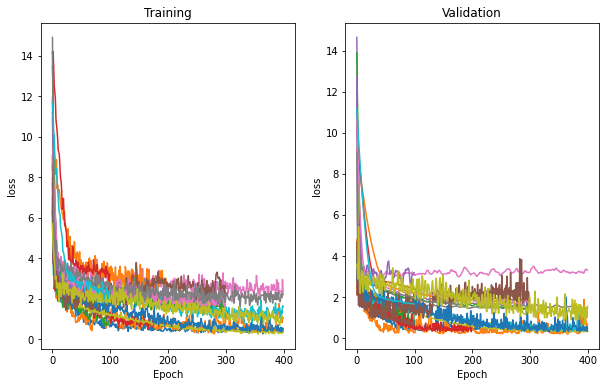

In [97]:
fig, ax = plt.subplots(1, 2, figsize=(10,6))
for i, tra in enumerate(train_l):
    ax[0].plot(tra)
ax[0].set_ylabel('loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title('Training')

for i, val in enumerate(val_l):
    ax[1].plot(val)
ax[1].set_ylabel('loss')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Validation')
    
plt.show()

In [98]:
def best_params(params, metric):
    last = []
    for m in metric:
        last.append( m[-1] )
    best = params[ np.argmin(last) ]
    return best

  0%|▍                                                                                 | 2/400 [00:00<00:27, 14.29it/s]

{'device': device(type='cuda'), 'dropout': 0.02313229338469185, 'num_epochs': 400, 'learning_rate': 0.0003989322552544819, 'optimizer': 'adam', 'regularization': 0, 'Nh': 75}
Network initialized


100%|████████████████████████████████████████████████████████████████████████████████| 400/400 [00:26<00:00, 14.99it/s]


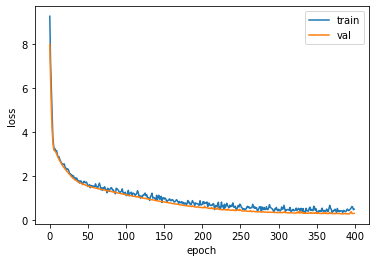

In [99]:
train_load = DataLoader(dataset, batch_size=20, shuffle=True, num_workers=0 )
val_load = train_load
loss = nn.MSELoss() 
# Best parameter selection
par_t = best_params(params, val_l)
print(par_t)
# Initialization of the net
Ni, Nh1, Nh2, No = 1, par_t['Nh'], 2*par_t['Nh'], 1
net = Net(Ni, Nh1, Nh2, No, par_t['dropout']).to(par_t['device'])
# Initialization of the optimizer
if par_t['optimizer']=='adam':
    opt = optim.Adam(net.parameters(), lr=par_t['learning_rate'], 
                     weight_decay=par_t['regularization'])
elif par_t['optimizer']=='sgd':
    opt = optim.SGD(net.parameters(), lr=par_t['learning_rate'], momentum=0.9,
                   weight_decay=par_t['regularization'])

# Training & validation
train_loss, val_loss = net.fit(train_load, val_load, opt, loss, par_t)

plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

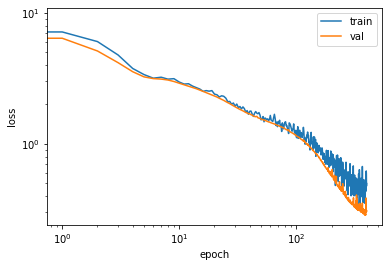

In [100]:
plt.plot(train_loss, label='train')
plt.plot(val_loss, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.loglog()
plt.show()

In [101]:
n = 1000
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = CsvDataset(x_data, transform=composed_transform)
x = DataLoader(x, batch_size=20, shuffle=False, num_workers=0 )

pred = net.predict(x, par_t['device'])#.flatten()

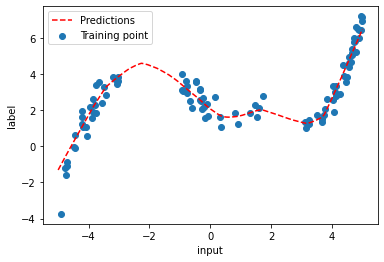

In [102]:
plt.scatter(data['input'], data['label'], label='Training point')
plt.plot(x_data['input'], pred.flatten(), 'r--', label='Predictions')
plt.legend()
plt.ylabel('label')
plt.xlabel('input')
plt.show()

In [103]:
# Best parameters of the network saved
#net.save('parameters')

# Testing performances

In [106]:
best_par = {'device': device, 'dropout': 0.02313229338469185, 
            'num_epochs': 400, 'learning_rate': 0.0003989322552544819, 
            'optimizer': 'adam', 'regularization': 0, 'Nh': 75}

net = Net(drop=best_par['dropout'], Nh1=best_par['Nh'], 
          Nh2=2*best_par['Nh'], Ni=1, No=1).to(device)

Network initialized


In [107]:
net.load('parameters')

In [108]:
test_set = pd.read_csv('regression_dataset/test_data.csv')
test_db = CsvDataset(data=test_set, transform=composed_transform)
test_load = DataLoader(test_db, batch_size=10, shuffle=False)
loss = nn.MSELoss() 

In [109]:
loss_test = net.test(test_db, best_par['device'], loss)
print('Loss on test set:', loss_test)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]C:\Users\win10\anaconda3\envs\Pytorch\lib\site-packages\torch\nn\modules\loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 909.43it/s]

Loss on test set: 0.26086482


In [110]:
n = 1000
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = CsvDataset(x_data, transform=composed_transform)
x = DataLoader(x, batch_size=20, shuffle=False, num_workers=0 )

pred = net.predict(x, best_par['device'])#.flatten()

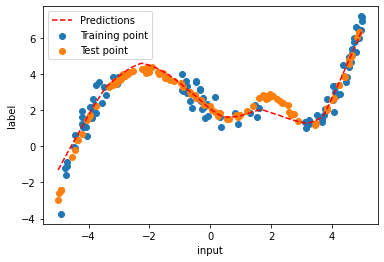

In [111]:
plt.scatter(data['input'], data['label'], label='Training point')
plt.scatter(test_set['input'], test_set['label'], label='Test point')
plt.plot(x_data['input'], pred.flatten(), 'r--', label='Predictions')
plt.legend()
plt.ylabel('label')
plt.xlabel('input')
plt.show()

# Weight analysis

In [112]:
h1_w = net.fc1.weight.detach().cpu().numpy()
h2_w = net.fc2.weight.detach().cpu().numpy()
out_w = net.out.weight.detach().cpu().numpy()

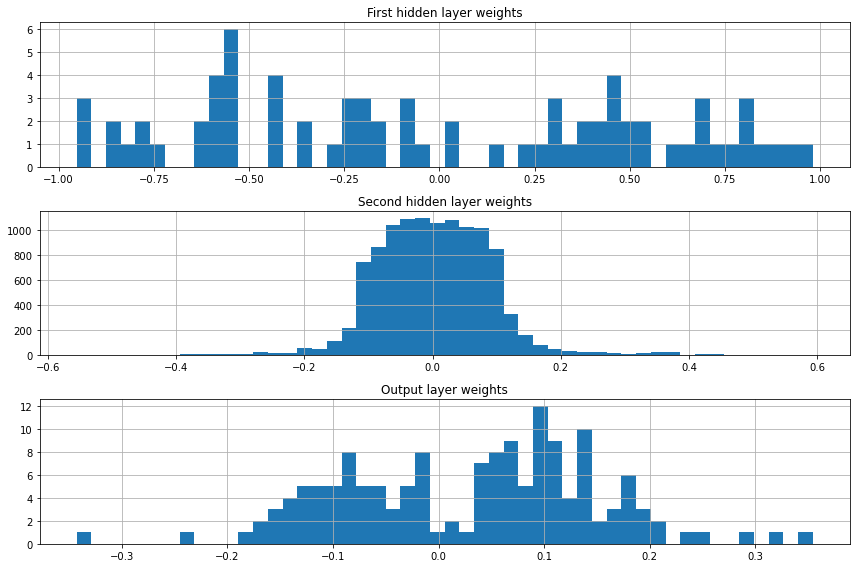

In [113]:
# Weights histogram
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].hist(h1_w, 50)
axs[0].set_title('First hidden layer weights')
axs[1].hist(h2_w.flatten(), 50)
axs[1].set_title('Second hidden layer weights')
axs[2].hist(out_w.flatten(), 50)
axs[2].set_title('Output layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.show()

## First layer

In [114]:
n = 20
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = CsvDataset(x_data, transform=composed_transform)
dataloader = DataLoader(x, batch_size=1, shuffle=False, num_workers=0 )

net.eval()
activations = []
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        # Forward pass
        out, act = net.forward(x_batch, additional_out=0)
        out = out.cpu().numpy()
        act = act.cpu().numpy()
        activations.append(act[0])
activations = np.array(activations)

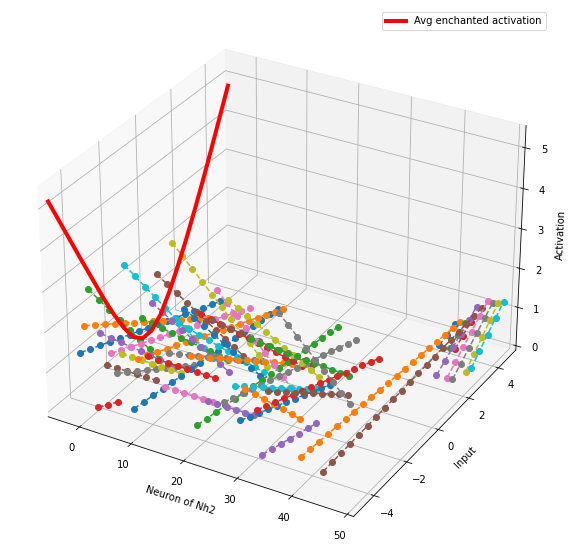

In [115]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x = x_data['input']
y = np.arange(0, 50)
sorting = np.argsort( activations[-1, :] )
z = activations[:, sorting ]
for  yi in y:
        cond = z[:, yi]>0.01
        ax.plot(np.repeat(yi, n)[cond], x[cond], z[:, yi][cond], 'o--')
    
ax.plot(np.repeat(-5, n), x, z.mean(axis=1)*5-1, linewidth=4, color='red',
       label='Avg enchanted activation')
ax.set_ylim3d(-5, 5)
ax.legend()
ax.set_xlim3d(-5, 50)
ax.set_zlim3d(0, np.max(activations) )    
ax.set_ylabel('Input')
ax.set_xlabel( 'Neuron of Nh2' )
ax.set_zlabel('Activation')
plt.show()

## Second layer

In [116]:
n = 20
x = np.hstack((np.linspace(-5,5, n).reshape(n,1), np.ones(n).reshape(n,1)))
x_data = pd.DataFrame( x.reshape(n,2), columns=['input', 'label'] )
x = CsvDataset(x_data, transform=composed_transform)
dataloader = DataLoader(x, batch_size=1, shuffle=False, num_workers=0 )

net.eval()
activations = []
with torch.no_grad(): # Disable gradient tracking
    for sample_batched in dataloader:
        # Move data to device
        x_batch = sample_batched[0].to(device)
        # Forward pass
        out, act = net.forward(x_batch, additional_out=1)
        out = out.cpu().numpy()
        act = act.cpu().numpy()
        activations.append(act[0])
activations = np.array(activations)

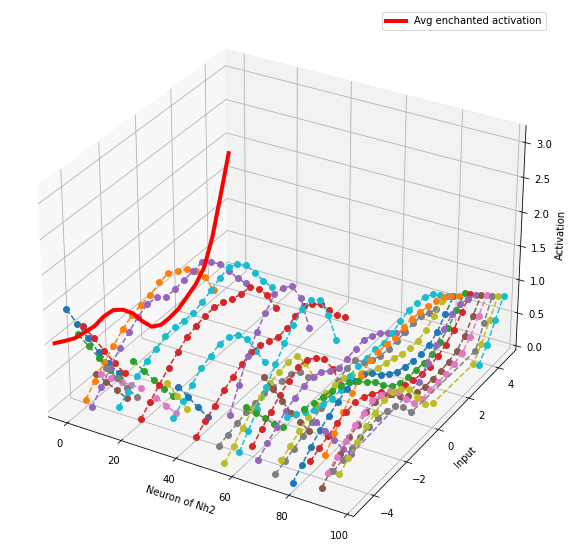

In [117]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1, projection='3d')
x = x_data['input']
y = np.arange(0, 100, 2)
sorting = np.argsort( activations[-1, :] )
z = activations[:, sorting ]
for  yi in y:
        cond = z[:, yi]>0.01
        ax.plot(np.repeat(yi, n)[cond], x[cond], z[:, yi][cond], 'o--')
    
ax.plot(np.repeat(-5, n), x, z.mean(axis=1)*5-1, linewidth=4, color='red',
       label='Avg enchanted activation')
ax.set_ylim3d(-5, 5)
ax.legend()
ax.set_xlim3d(-5, 100)
ax.set_zlim3d(0, np.max(activations) )    
ax.set_ylabel('Input')
ax.set_xlabel( 'Neuron of Nh2' )
ax.set_zlabel('Activation')
plt.show()